In [1]:
import os
import django
from django.db import connection
import sys
sys.path.append('../')
import pandas as pd
import matplotlib.pyplot as plt
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'activity_viewer.settings')
django.setup()

In [2]:
from dashboard.models import Log

In [3]:
# kwargs match the name of the field in the class definition in models.p
full_file_download_logs = Log.objects.filter(http_status=200)
# Double underscore follows a foreign key relationship and accesses a field there
# Example: Log has an item foreign key which has an experiment foreign key which has a field called 'name'
# Notice that queries can be chained together. They are executed lazily, when the data is actually fetched and used
wanted_log_fields = full_file_download_logs.values_list('pk', 'ip_address', 's3_key', 'item__experiment__name', 'item__lab__name')

In [4]:
# Necessary to create columns since we used values_list, not values, which is a tuple not a dictionary
logs_df = pd.DataFrame(wanted_log_fields, columns=['pk', 'ip', 'key', 'experiment', 'lab'])

In [5]:
# A unique combo of key and ip drops the times when the same computer downloaded a file multiple times
# This is usually faster than the database since it is only in-memory
unique_downloads_df = logs_df.drop_duplicates(subset=['key', 'ip'])
# Finding the experiment that have the most logs representing a unique download
most_uniquely_used_experiments = unique_downloads_df.groupby(by='experiment').size().sort_values(ascending=False)

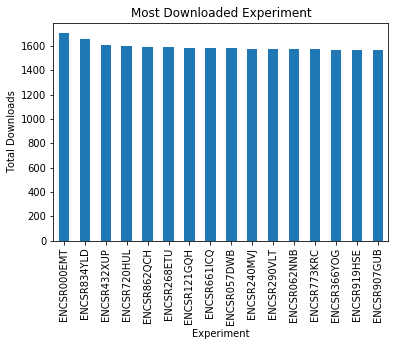

In [6]:
axes = most_uniquely_used_experiments[:16].plot(kind='bar')
axes.set(xlabel="Experiment", ylabel="Total Downloads", title='Most Downloaded Experiment')
plt.show()

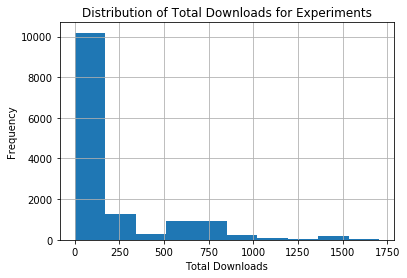

In [7]:
axes = most_uniquely_used_experiments.hist()
axes.set(xlabel='Total Downloads', ylabel='Frequency', title='Distribution of Total Downloads for Experiments')
plt.show()

In [8]:
# Same idea as before but now with lab not experiment
labs_with_most_uniquely_accessed_files = unique_downloads_df.groupby('lab').size().sort_values(ascending=False)[:16]

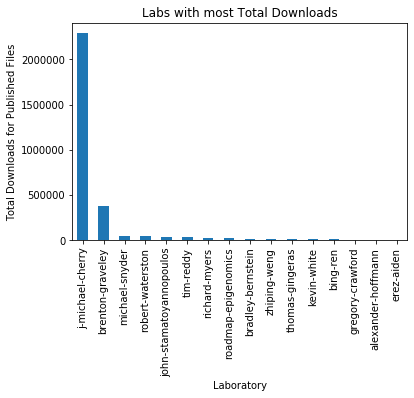

In [9]:
axes = labs_with_most_uniquely_accessed_files.plot(kind='bar')
axes.set(xlabel="Laboratory", ylabel="Total Downloads for Published Files", title='Labs with most Total Downloads')
plt.show()

In [10]:
print(connection.queries)

[{'sql': 'SELECT "dashboard_log"."id", "dashboard_log"."ip_address", "dashboard_log"."s3_key", "dashboard_experiment"."name", "dashboard_lab"."name" FROM "dashboard_log" LEFT OUTER JOIN "dashboard_item" ON ("dashboard_log"."item_id" = "dashboard_item"."id") LEFT OUTER JOIN "dashboard_experiment" ON ("dashboard_item"."experiment_id" = "dashboard_experiment"."id") LEFT OUTER JOIN "dashboard_lab" ON ("dashboard_item"."lab_id" = "dashboard_lab"."id") WHERE "dashboard_log"."http_status" = 200', 'time': '72.236'}]
